# Cornell Movie Dialog Dataset Analysis by 'Webwizards'

**Contributors:**

*  Daniel Matthias KEREZSY
*   [Rishikesh Miriyala](https://github.com/Rishi24109)
*   [Nishith Ranjan Biswas](https://github.com/Nishith170217)







**Overview**

This repository hosts the analysis of the Cornell Movie Dialogs dataset for a Natural Language Processing course project at Politecnico di Milano (Polimi). This project aims to leverage various NLP techniques to explore and model movie script dialogues, enabling a deeper understanding of conversational dynamics in films. This README outlines the dataset details, analysis methods, and insights gained from modeling efforts.

**Dataset Description**

The Cornell Movie Dialogs dataset is a comprehensive compilation of movie character dialogues and associated metadata. Here are some key details:

**Source:**  [Cornell Movie Dialogs Dataset on Hugging Face](https://huggingface.co/datasets/cornell_movie_dialog)
    

**Reference Paper:** [Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs](https://arxiv.org/abs/1106.3077)

**Content Description:** The dataset contains movie dialogue scripts accompanied by detailed metadata, such as film title, characters involved, and more.

**Documents Type:** Includes dialogues exchanged between movie characters.
Size: Contains 220,579 conversational exchanges between 10,292 pairs of movie characters involves 9,035 characters from 617 movies.

**movie metadata included:**

1.   genres
2.   release year
3.   IMDB rating
4. number of IMDB votes
5. character

**metadata included:**

1. gender (for 3,774 characters)
2. position on movie credits (3,321 characters)

**Primary Tasks:**



*   Film Dialog Generation: Generate contextually appropriate responses based on previous dialogue exchanges.
*   Prediction of Metadata: Predict metadata attributes like film title or character traits based on specific dialogues.



In [ ]:
# Import necessary libraries
from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import the Libraries that we will need:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
import ast
from sklearn.preprocessing import MultiLabelBinarizer

Upload the Cornel Movie Dataset as Lines, Conversations, Characters and Titles

In [ ]:
lines = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/data/movie_lines.tsv",
    encoding='utf-8-sig',
    sep='\t',
    on_bad_lines="skip",
    header = None,
    names = ['lineID', 'charID', 'movieID', 'charName', 'text'],
    index_col=['lineID']
)

In [ ]:
conversations = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/data/movie_conversations.tsv",
    sep='\t',
    encoding='ISO-8859-2',
    names = ['charID_1', 'charID_2', 'movieID', 'conversation']
)

In [ ]:
characters = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/data/movie_characters_metadata.tsv",
    sep='\t',
    header = None,
    on_bad_lines= "skip",
    names = ['charID','charName','movieID','movieName','gender','score'],
    index_col=['charID']
)

In [ ]:
titles = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/data/movie_titles_metadata.tsv",
    sep='\t',
    header=None,
    on_bad_lines="skip",
    names=['movieID', 'title', 'year', 'ratingIMDB', 'votes', 'genresIMDB'],
    index_col=['movieID']
)

# Preliminary Analysis of the Dataset:
Check the coloumns whether information exist or null.

In [ ]:
def check_columns_existence(df, columns):
    for col in columns:
        if col not in df.columns:
            print(f"The column '{col}' does not exist in DataFrame")
        else:
            print(f"The column '{col}' exists in DataFrame")

# Check if columns exist in each DataFrame
check_columns_existence(characters, ['charName'])
check_columns_existence(titles, ['title'])
check_columns_existence(lines, ['charName', 'text'])
check_columns_existence(conversations, ['charID_1', 'charID_2', 'movieID', 'conversation'])

The column 'charName' exists in DataFrame
The column 'title' exists in DataFrame
The column 'charName' exists in DataFrame
The column 'text' exists in DataFrame
The column 'charID_1' exists in DataFrame
The column 'charID_2' exists in DataFrame
The column 'movieID' exists in DataFrame
The column 'conversation' exists in DataFrame


Extract some data using info() which provides detailed information of the structure.

In [ ]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617 entries, m0 to m616
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       616 non-null    object 
 1   year        616 non-null    object 
 2   ratingIMDB  616 non-null    float64
 3   votes       616 non-null    float64
 4   genresIMDB  616 non-null    object 
dtypes: float64(2), object(3)
memory usage: 28.9+ KB


Inspect the first few rows using head()

In [ ]:
titles.head()

title  year  ratingIMDB     votes  \
movieID                                                           
m0       10 things i hate about you  1999         6.9   62847.0   
m1       1492: conquest of paradise  1992         6.2   10421.0   
m2                       15 minutes  2001         6.1   25854.0   
m3            2001: a space odyssey  1968         8.4  163227.0   
m4                          48 hrs.  1982         6.9   22289.0   

                                             genresIMDB  
movieID                                                  
m0                                 ['comedy' 'romance']  
m1          ['adventure' 'biography' 'drama' 'history']  
m2                ['action' 'crime' 'drama' 'thriller']  
m3                     ['adventure' 'mystery' 'sci-fi']  
m4       ['action' 'comedy' 'crime' 'drama' 'thriller']

It is possible that some columns might be empty. Let's find out by using isnull()

In [ ]:
# Check for missing values
print(titles.isnull().sum())

title         1
year          1
ratingIMDB    1
votes         1
genresIMDB    1
dtype: int64


**Visualization:** Create a Histogram of the Votes Distribution

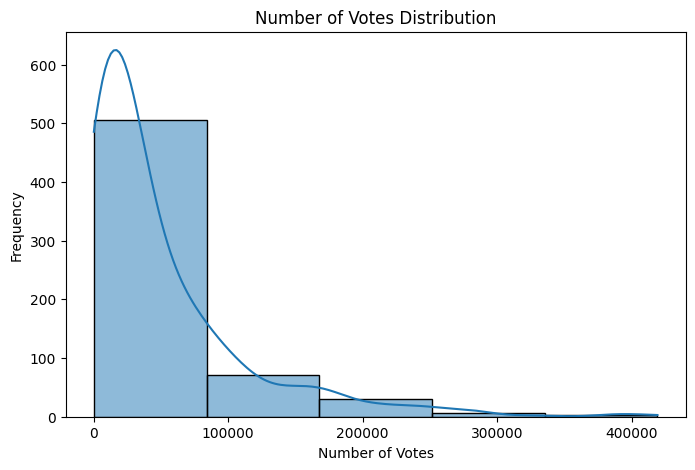

In [ ]:
# Number of Votes Distribution
plt.figure(figsize=(8, 5))
sns.histplot(titles['votes'], bins=5, kde=True)
plt.title('Number of Votes Distribution')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.show()

Add Ratings as a List

In [ ]:
ratings_list = titles['ratingIMDB'].tolist()
print(ratings_list)

[6.9, 6.2, 6.1, 8.4, 6.9, 7.5, 6.3, 5.2, 4.7, 4.9, 6.9, 6.3, 5.8, 7.8, 6.1, 8.5, 8.4, 7.5, 7.4, 5.7, 7.4, 6.0, 7.1, 3.4, 5.9, 6.6, 6.9, 6.3, 8.1, 6.3, 8.1, 6.0, 7.1, 6.4, 8.3, 6.4, 7.8, 7.8, 7.2, 7.6, 8.4, 7.8, 8.8, 7.5, 7.5, 6.8, 7.2, 6.5, 5.3, 6.5, 8.3, 6.3, 8.1, 8.4, 5.9, 8.5, 4.0, 6.4, 5.7, 7.2, 7.6, 6.4, 7.2, 8.0, 5.6, 7.1, 5.6, 4.9, 7.2, 7.5, 6.9, 5.3, 7.7, 6.6, 6.1, 6.9, 8.4, 8.2, 7.7, 7.0, 5.4, 4.5, 5.8, 6.7, 8.1, 6.2, 6.8, 7.0, 7.6, 7.2, 8.1, 7.4, 5.6, 6.3, 8.2, 7.1, 6.4, 6.6, 8.3, 7.5, 6.5, 8.0, 6.4, 8.3, 8.0, 7.6, 7.5, 4.4, 8.3, 7.9, 6.7, 6.8, 5.8, 5.9, 8.6, 4.5, 7.6, 6.2, 6.2, 7.5, 7.3, 5.0, 6.7, 7.6, 7.8, 7.0, 7.7, 6.4, 7.7, 7.7, 7.7, 7.8, 7.7, 5.3, 8.4, 8.2, 5.5, 4.5, 6.7, 8.4, 8.0, 6.8, 6.9, 5.9, 5.5, 5.4, 6.2, 8.2, 7.4, 7.9, 7.1, 8.3, 6.4, 7.8, 6.8, 6.9, 5.9, 6.9, 6.3, 7.2, 6.7, 6.9, 7.5, 7.4, 7.3, 7.1, 8.4, 8.7, 7.9, 5.5, 8.4, 6.9, 4.7, 6.4, 6.9, 7.1, 6.5, 5.4, 7.8, 6.9, 7.0, 8.3, 8.2, 4.2, 6.6, 6.6, 6.6, 6.2, 6.1, 7.4, 8.2, 6.5, 6.5, 7.8, 7.3, 6.3, 7.6, 7.2, 6.4, 6.9,

Find out the distribution of ratings of the movies

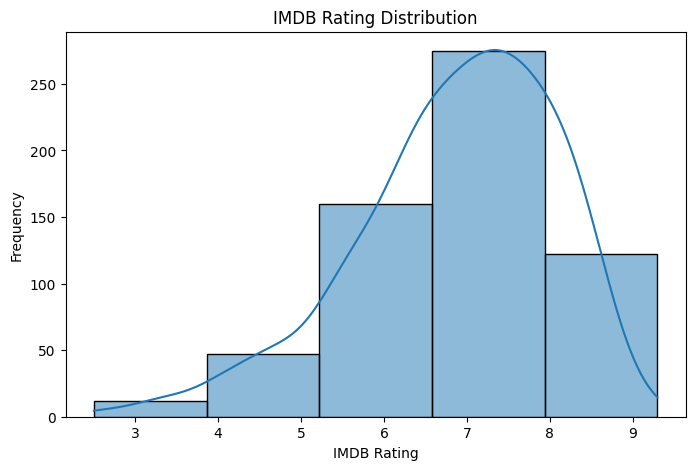

In [ ]:
# IMDB Rating Distribution
plt.figure(figsize=(8, 5))
sns.histplot(titles['ratingIMDB'], bins=5, kde=True)
plt.title('IMDB Rating Distribution')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency')
plt.show()

We categorized the ratings into 3 groups, where,0-4 refers 'Lower ratings', 5-6 refers 'Good', and 7-10 refers very good. The bar chart describes the catergory really well

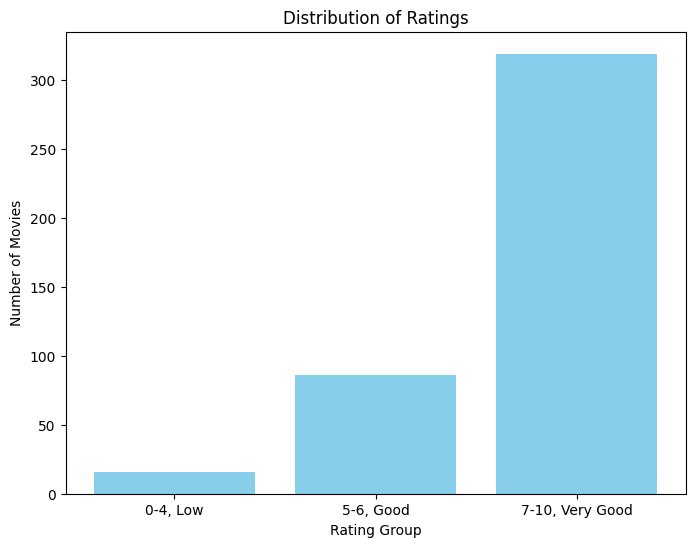

In [ ]:
# Categorize ratings into 3 groups (0-4, 5-6, 7-10)
rating_groups = {
    '0-4, Low': sum(1 for rating in ratings_list if rating <= 4),
    '5-6, Good': sum(1 for rating in ratings_list if 5 <= rating <= 6),
    '7-10, Very Good': sum(1 for rating in ratings_list if rating >= 7)
}

# Plotting the data
plt.figure(figsize=(8, 6))
plt.bar(rating_groups.keys(), rating_groups.values(), color='skyblue')
plt.xlabel('Rating Group')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings')
plt.show()

Just another Piechart presentation

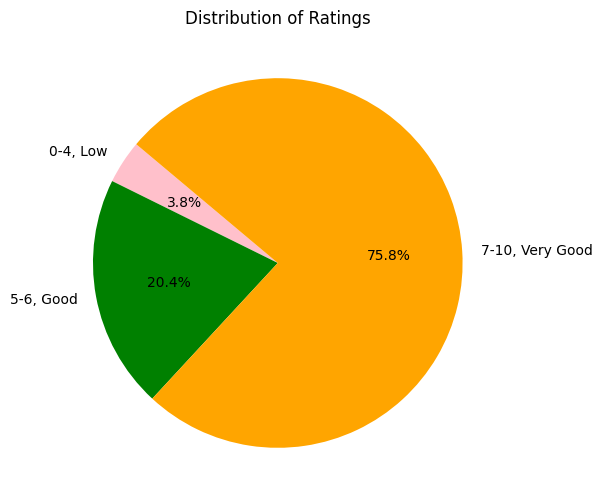

In [ ]:
# Plotting the data
plt.figure(figsize=(8, 6))
plt.pie(rating_groups.values(), labels=rating_groups.keys(), autopct='%1.1f%%', startangle=140, colors=['pink', 'green', 'orange'])
plt.title('Distribution of Ratings')
plt.show()

This function Finds the rating of a particular movie

In [ ]:
 # Search for the movie by title and get its rating
def search_movie_rating(title):
    movie_rating = titles.loc[titles['title'].str.contains(title, case=False, na=False), 'ratingIMDB']

    if not movie_rating.empty:
        return movie_rating.values[0]
    else:
        return "Movie not found or no rating available."

#movie_to_search = input("Enter the title of the movie to search for: ")
movie_to_search= '48 hrs.'
rating = search_movie_rating(movie_to_search)
print(f"The rating for '{movie_to_search}' is: {rating}")
if rating<= 4:
  print('According to our analysis its a Low ranked movie!')
elif rating <=6:
  print('According to our analysis its a Good ranked movie!')
else:
  print('According to our analysis its a Very good ranked movie!')


The rating for '48 hrs.' is: 6.9
According to our analysis its a Very good ranked movie!


**Visualization:** Vote Distribution using bar chart:



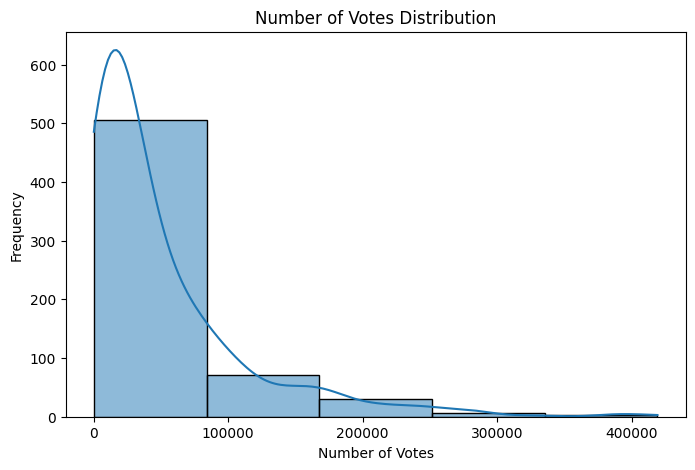

In [ ]:
# Number of Votes Distribution
plt.figure(figsize=(8, 5))
sns.histplot(titles['votes'], bins=5, kde=True)
plt.title('Number of Votes Distribution')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.show()

Comparision of IMDB ratings and Votes using Scatter Plot:

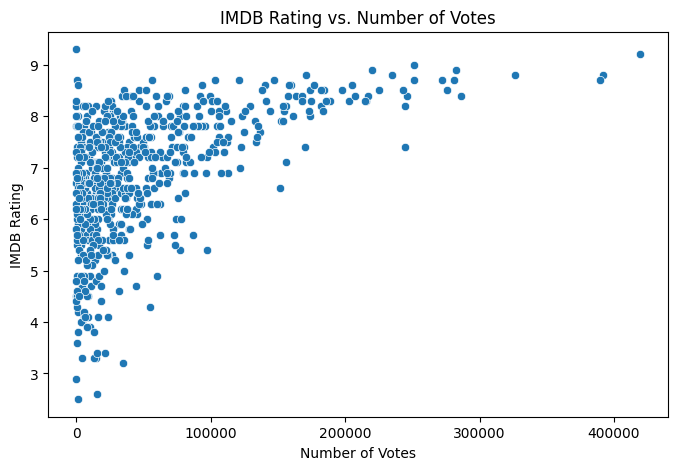

In [ ]:
# IMDB Rating vs. Number of Votes
plt.figure(figsize=(8, 5))
sns.scatterplot(x='votes', y='ratingIMDB', data=titles)
plt.title('IMDB Rating vs. Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('IMDB Rating')
plt.show()

3D-Plotting as per Year,IMDB rating and Votes

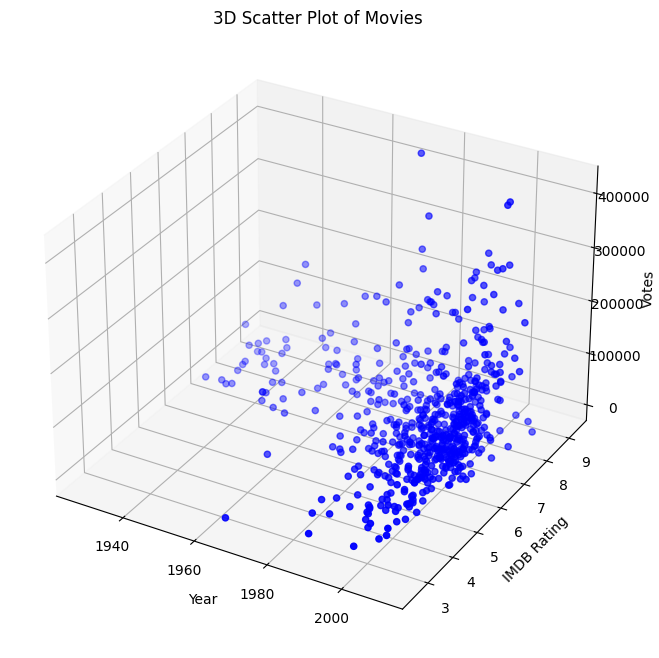

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Clean the "year" column
titles['year'] = titles['year'].str.extract(r'(\d+)').astype(float)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(titles['year'], titles['ratingIMDB'], titles['votes'], c='b', marker='o')

# Customize labels and title
ax.set_xlabel('Year')
ax.set_ylabel('IMDB Rating')
ax.set_zlabel('Votes')
ax.set_title('3D Scatter Plot of Movies')

# Show plot
plt.show()

Check the list of genres present in the dataset. By representing as a list we can easily access and manipulate the information associated in single tile.

In [ ]:
def get_genre_list(genres):
    genre_list = genres['genresIMDB'].tolist()
    return genre_list

In [ ]:
genre_list = get_genre_list(titles)
print(genre_list[:100])

["['comedy' 'romance']", "['adventure' 'biography' 'drama' 'history']", "['action' 'crime' 'drama' 'thriller']", "['adventure' 'mystery' 'sci-fi']", "['action' 'comedy' 'crime' 'drama' 'thriller']", "['action' 'adventure' 'romance' 'sci-fi' 'thriller']", "['crime' 'mystery' 'thriller']", "['fantasy' 'horror' 'thriller']", "['fantasy' 'horror' 'thriller']", "['sci-fi' 'thriller']", "['drama' 'mystery' 'thriller']", "['action' 'drama' 'thriller']", "['comedy' 'romance' 'sci-fi']", "['comedy' 'romance']", "['crime' 'drama' 'sci-fi' 'thriller']", "['action' 'sci-fi' 'thriller']", "['biography' 'drama' 'music']", "['horror' 'romance']", "['drama']", "['action' 'western']", "['drama' 'thriller']", "['drama' 'thriller']", "['action' 'adventure' 'comedy' 'crime']", "['action' 'adventure' 'thriller']", "['comedy' 'romance']", "['action' 'crime' 'drama' 'mystery' 'thriller']", "['crime' 'drama']", "['comedy' 'drama' 'music']", "['drama' 'romance' 'war']", "['crime' 'drama' 'mystery' 'thriller']"

In [ ]:
type(genre_list)

list

Splitting the genres as most of the movies have more than one genre & finding out how many unique genres are there among the whole genre list

In [ ]:
# Initialize an empty list to store all genres
all_genres = []

# Loop through each nested list and extract genres
for genres in genre_list:
    if isinstance(genres, str):
        # Remove the brackets and split the string into individual genres
        cleaned_genres = genres.strip("[]").replace("'", "").split()
        # Extend the all_genres list with the cleaned genres
        all_genres.extend(cleaned_genres)

# Convert the list to a set to remove duplicates and then back to a sorted list
unique_genres_list = sorted(set(all_genres))

# Display the unique genres
print(unique_genres_list)

['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sci-fi', 'short', 'sport', 'thriller', 'war', 'western']


Use len() to find the length of genres list

In [ ]:
len(all_genres)

1868

Let's find out which genres are present in the list.


In [ ]:
print(all_genres)

['comedy', 'romance', 'adventure', 'biography', 'drama', 'history', 'action', 'crime', 'drama', 'thriller', 'adventure', 'mystery', 'sci-fi', 'action', 'comedy', 'crime', 'drama', 'thriller', 'action', 'adventure', 'romance', 'sci-fi', 'thriller', 'crime', 'mystery', 'thriller', 'fantasy', 'horror', 'thriller', 'fantasy', 'horror', 'thriller', 'sci-fi', 'thriller', 'drama', 'mystery', 'thriller', 'action', 'drama', 'thriller', 'comedy', 'romance', 'sci-fi', 'comedy', 'romance', 'crime', 'drama', 'sci-fi', 'thriller', 'action', 'sci-fi', 'thriller', 'biography', 'drama', 'music', 'horror', 'romance', 'drama', 'action', 'western', 'drama', 'thriller', 'drama', 'thriller', 'action', 'adventure', 'comedy', 'crime', 'action', 'adventure', 'thriller', 'comedy', 'romance', 'action', 'crime', 'drama', 'mystery', 'thriller', 'crime', 'drama', 'comedy', 'drama', 'music', 'drama', 'romance', 'war', 'crime', 'drama', 'mystery', 'thriller', 'adventure', 'drama', 'fantasy', 'comedy', 'crime', 'roman

In [ ]:
len(unique_genres_list)

24

Which genre is more frequent in our dataset ?

From the barchart we can easliy see that the drama and thriller movies dominate the chart

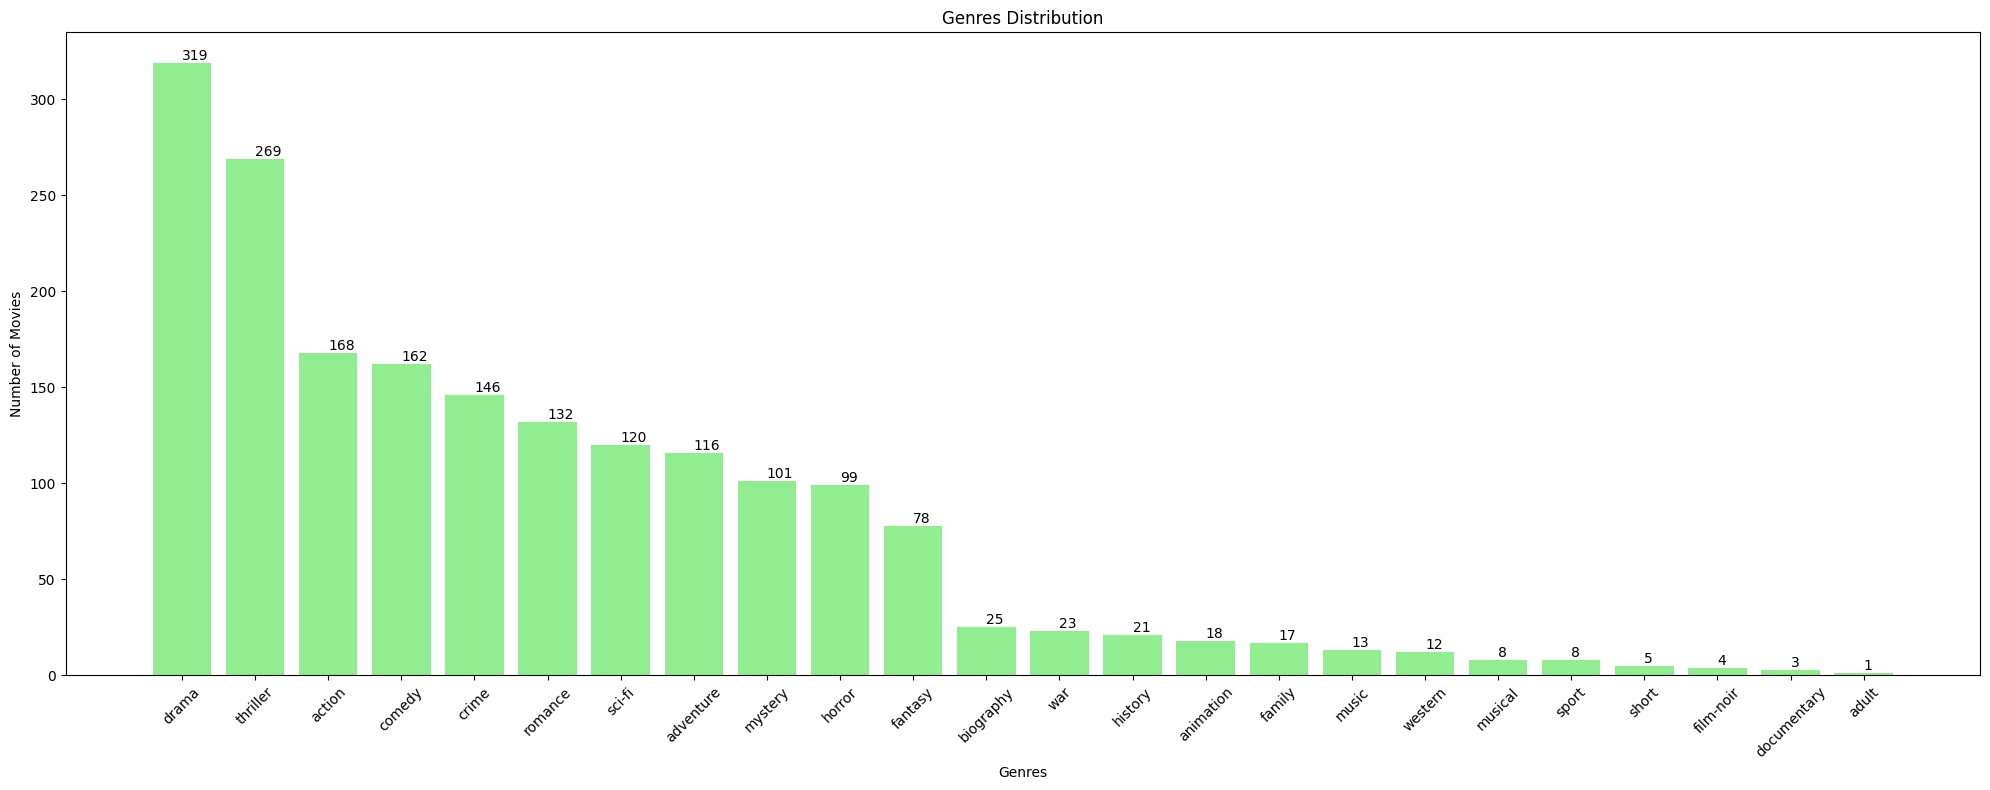

In [ ]:
# Count the frequency of each word
word_counts = {}
for word in all_genres:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

# Create a DataFrame from the word counts
df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency
df = df.sort_values(by='Frequency', ascending=False)

# Plotting the data
plt.figure(figsize=(20, 8))
bars = plt.bar(df['Word'], df['Frequency'], color='lightgreen')
plt.bar(df['Word'], df['Frequency'], color='lightgreen')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.title('Genres Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add text labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.tight_layout()
plt.show()

Plot the ratings of genres set

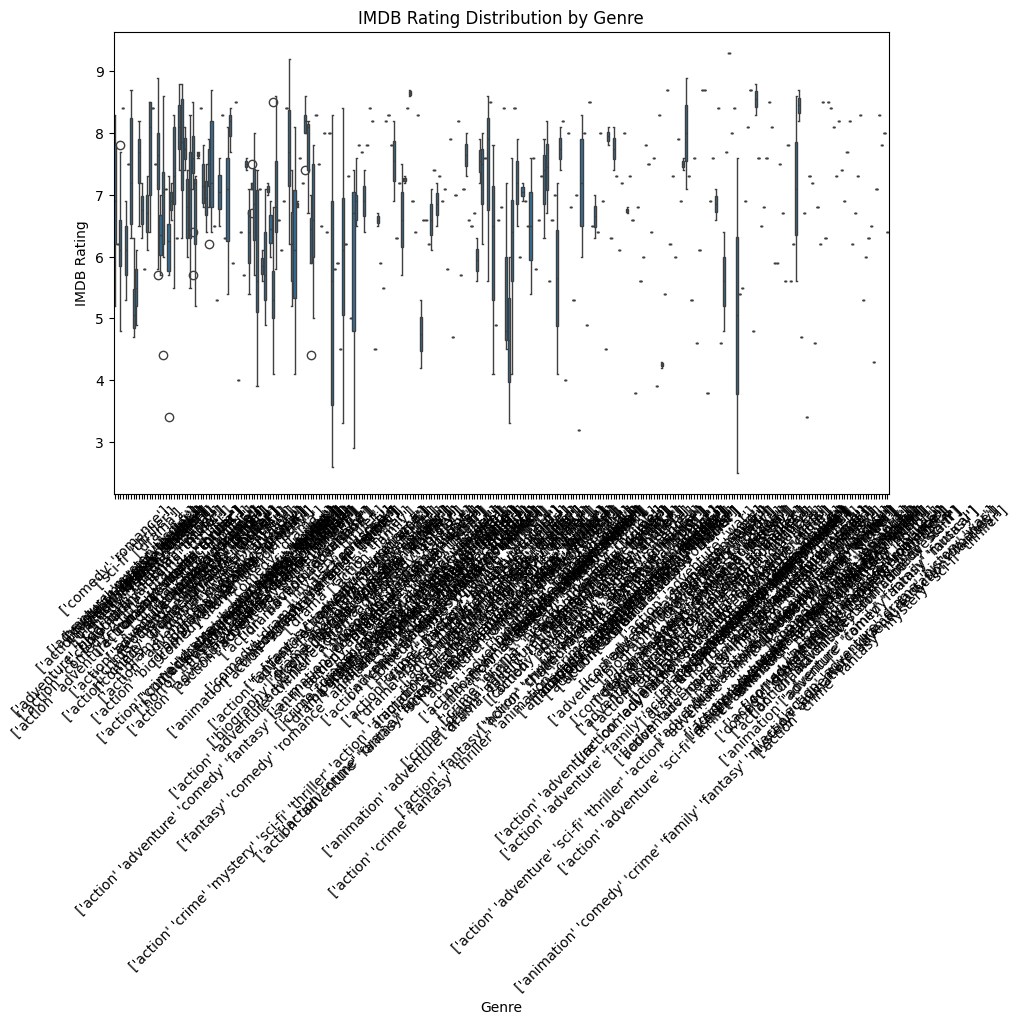

In [ ]:

# Explode genres list to separate rows
genres_exploded = titles.explode('genresIMDB')

# IMDB Rating Distribution by Genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='genresIMDB', y='ratingIMDB', data=genres_exploded)
plt.title('IMDB Rating Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('IMDB Rating')
plt.xticks(rotation=45)
plt.show()

Find out the genre of a particular movie: here we took "48hrs" as an example

In [ ]:
df= titles
def find_genres(keyword):
    # Search for the keyword in the movie titles
    matching_movies = df[df['title'].str.contains(keyword, case=False, na=False)]

    if not matching_movies.empty:
        # If there's a match, return the movie title and genres as a list of tuples
        x = [(row['title'], row['genresIMDB']) for index, row in matching_movies.iterrows()]
        result_dict = {key: [genre.strip("'") for genre in value.strip("[]").split(", ")] for key, value in x}
        os = f"Movie: {list(result_dict.keys())[0]}\nGenres = {result_dict[list(result_dict.keys())[0]]}"
        return os
    else:
        return "No matching movie found."

#movie_name = input("Enter the title of the movie to search genre: ")
movie_name= '48 hrs.'
genres = find_genres(movie_name)
print(genres)

Movie: 48 hrs.
Genres = ["action' 'comedy' 'crime' 'drama' 'thriller"]


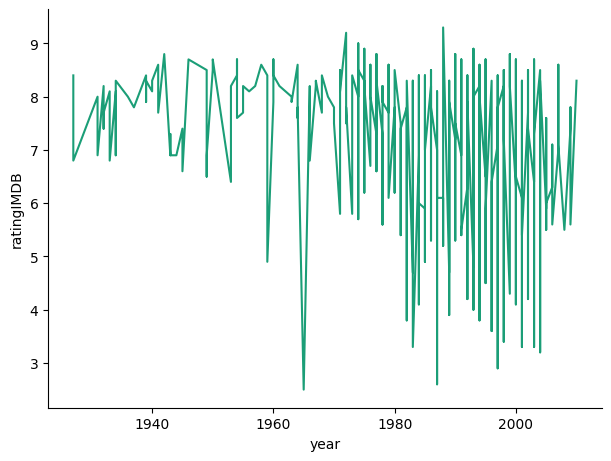

In [ ]:
# @title year vs ratingIMDB

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['ratingIMDB']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(6, 4.5), layout='constrained')
df_sorted = titles.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('ratingIMDB')

**Searching movies using genre:**



In [ ]:
def find_movies_by_genre(dataframe, genre):
    # Creating a copy of the dataframe to avoid modifying the original
    dataframe_copy = dataframe.copy()

    # Replace NaN values with an empty list in the 'genresIMDB' column in the copy
    dataframe_copy['genresIMDB'].fillna('[]', inplace=True)

    # Convert the genre column to a list of strings in the copy
    dataframe_copy['genresIMDB'] = dataframe_copy['genresIMDB'].apply(ast.literal_eval)

    # Convert genre to lowercase for case-insensitive matching
    genre_lower = genre.lower()

    # Filter the copy of the dataframe to find movies with the specified genre
    filtered_movies = dataframe_copy[dataframe_copy['genresIMDB'].apply(lambda x: any(genre_lower in g.lower() for g in x))]

    return filtered_movies[['title', 'year', 'ratingIMDB']]


We are interested in Action movies so, let's see which action movies we can find from the dataset.

In [ ]:
genre_to_search = 'action'
#genre_to_search = input("Enter the genre to search genre: ")
movies_with_genre = find_movies_by_genre(titles, genre_to_search)
print(f"Movies with genre '{genre_to_search}':")
print(movies_with_genre[:10])

Movies with genre 'action':
                                               title    year  ratingIMDB
movieID                                                                 
m2                                        15 minutes  2001.0         6.1
m4                                           48 hrs.  1982.0         6.9
m5                                 the fifth element  1997.0         7.5
m11                                    air force one  1997.0         6.3
m15                                           aliens  1986.0         8.5
m19                                 american outlaws  2001.0         5.7
m22      austin powers: international man of mystery  1997.0         7.1
m23                                     the avengers  1998.0         3.4
m25                                        backdraft  1991.0         6.6
m33                                       black rain  1989.0         6.4


# How about Horror movies ?

In [ ]:
genre_to_search = 'horror'
#genre_to_search = input("Enter the genre to search genre: ")
movies_with_genre = find_movies_by_genre(titles, genre_to_search)
print(f"Movies with genre '{genre_to_search}':")
print(movies_with_genre[:10])

Movies with genre 'horror':
                                                 title    year  ratingIMDB
movieID                                                                   
m7       a nightmare on elm street 4: the dream master  1988.0         5.2
m8          a nightmare on elm street: the dream child  1989.0         4.7
m17                     an american werewolf in london  1981.0         7.5
m48                                         dark angel  1990.0         5.3
m57                                      event horizon  1997.0         6.4
m61                                              feast  2005.0         6.4
m63                                       frankenstein  1931.0         8.0
m64                                    friday the 13th  2009.0         5.6
m65                                from dusk till dawn  1996.0         7.1
m67                                           godzilla  1998.0         4.9


# Word Cloud of Movie Titles

**A Sneak Peak into the movies present in our dataset**

Wordcloud is used to visualize the text data as a collection where the size indicates the frequency or importance within the text.

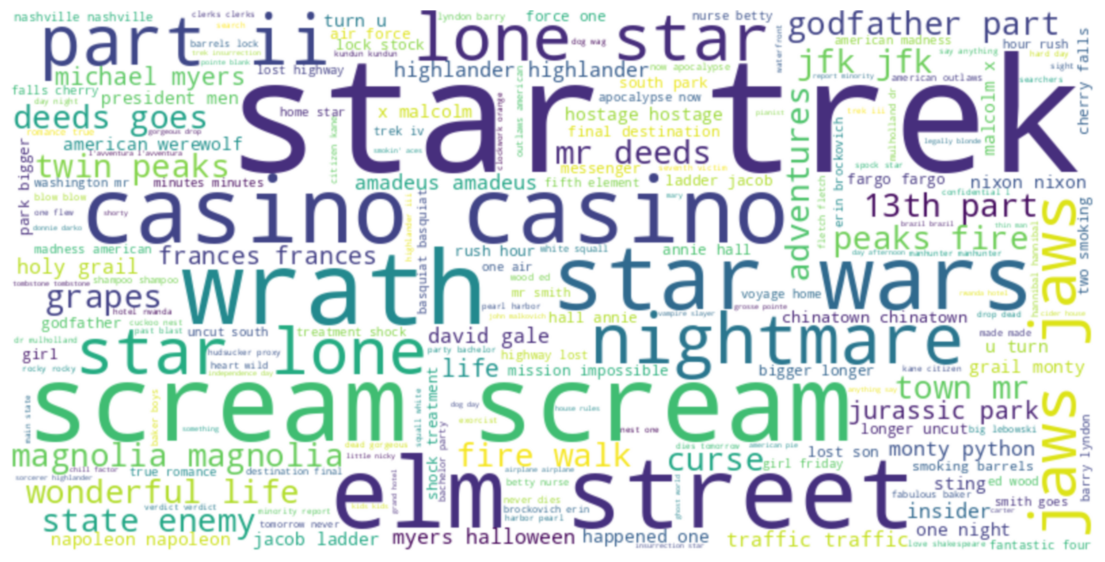

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Convert the "title" column to string type
characters['movieName'] = characters['movieName'].astype(str)

# Extract the "title" column
mvs = characters['movieName']

# Concatenate all titles into a single string
text = ' '.join(mvs)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis('off')
plt.show()

# Characters Data

In [ ]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9034 entries, u0 to u9034
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   charName   9015 non-null   object 
 1   movieID    9017 non-null   object 
 2   movieName  9034 non-null   object 
 3   gender     9017 non-null   object 
 4   score      2679 non-null   float64
dtypes: float64(1), object(4)
memory usage: 681.5+ KB


In [ ]:
characters.head()

charName movieID                   movieName   gender  score
charID                                                              
u0        BIANCA      m0  10 things i hate about you        f    4.0
u1         BRUCE      m0  10 things i hate about you  unknown    NaN
u2       CAMERON      m0  10 things i hate about you        m    3.0
u3      CHASTITY      m0  10 things i hate about you  unknown    NaN
u4          JOEY      m0  10 things i hate about you        m    6.0

**Visualization :** gender vs score

<ipython-input-84-5ad4fd7d17ec>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(characters, x='score', y='gender', inner='box', palette='Dark2')


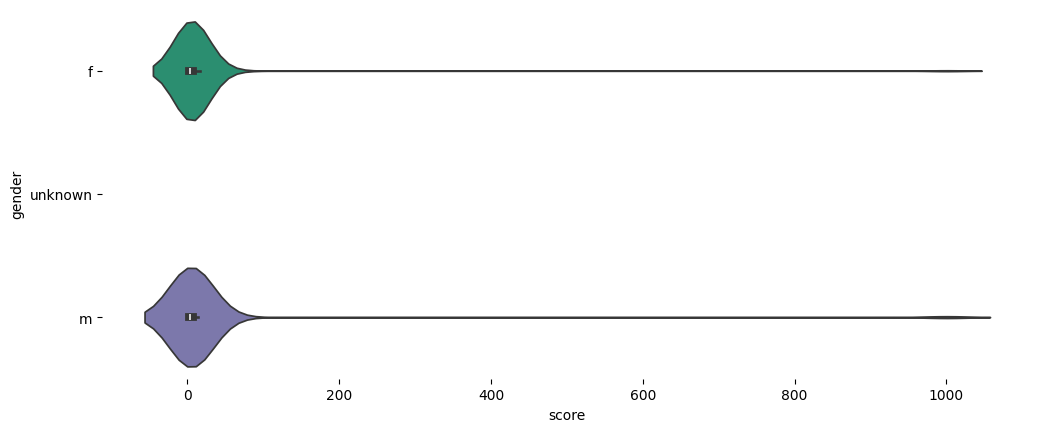

In [ ]:
#  gender vs score

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(characters['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(characters, x='score', y='gender', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
print(characters['gender'].value_counts())

gender
unknown    6008
m          1899
f           921
M           145
F            44
Name: count, dtype: int64


Standardizing the representation by converting into lowercase for further modelling.


As we can see some values in the gender and score column are absent.

Therefore, Replaces any '?' in the gender column with 'unknown', and Converts the score column to numeric values, setting non-convertible entries to NaN.

In [ ]:
# Data Cleaning
characters['gender'] = characters['gender'].str.lower().replace('?', 'unknown')
characters['score'] = pd.to_numeric(characters['score'], errors='coerce')

# Display cleaned data
#print(characters['gender'].value_counts())
print(characters)


             charName movieID                   movieName   gender  score
charID                                                                   
u0             BIANCA      m0  10 things i hate about you        f    4.0
u1              BRUCE      m0  10 things i hate about you  unknown    NaN
u2            CAMERON      m0  10 things i hate about you        m    3.0
u3           CHASTITY      m0  10 things i hate about you  unknown    NaN
u4               JOEY      m0  10 things i hate about you        m    6.0
...               ...     ...                         ...      ...    ...
u9030        DURNFORD    m616                   zulu dawn  unknown    NaN
u9031         MELVILL    m616                   zulu dawn  unknown    NaN
u9032   NORRIS-NEWMAN    m616                   zulu dawn  unknown    NaN
u9033    STUART SMITH    m616                   zulu dawn  unknown    NaN
u9034         VEREKER    m616                   zulu dawn  unknown    NaN

[9034 rows x 5 columns]


Frequency of each gender category.

In [ ]:
print(characters['gender'].value_counts())

gender
unknown    6008
m          2044
f           965
Name: count, dtype: int64


Plotting the gender distribution.

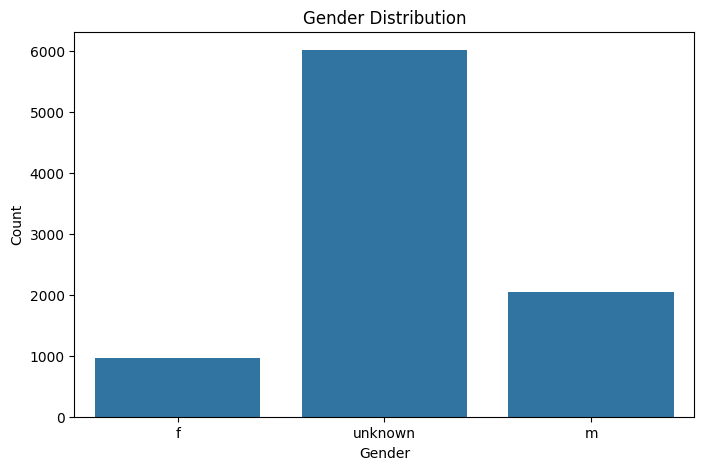

In [ ]:
# Gender Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', data=characters)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Plot the score of characters

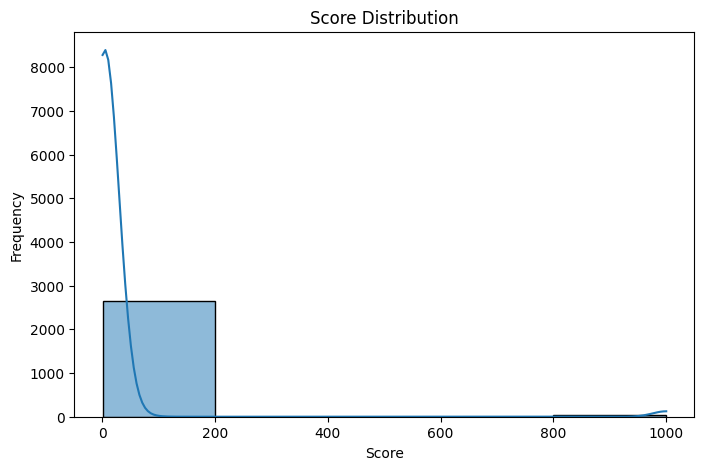

In [ ]:
# Score Distribution
plt.figure(figsize=(8, 5))
sns.histplot(characters['score'].dropna(), bins=5, kde=True)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


Plot the character score by gender

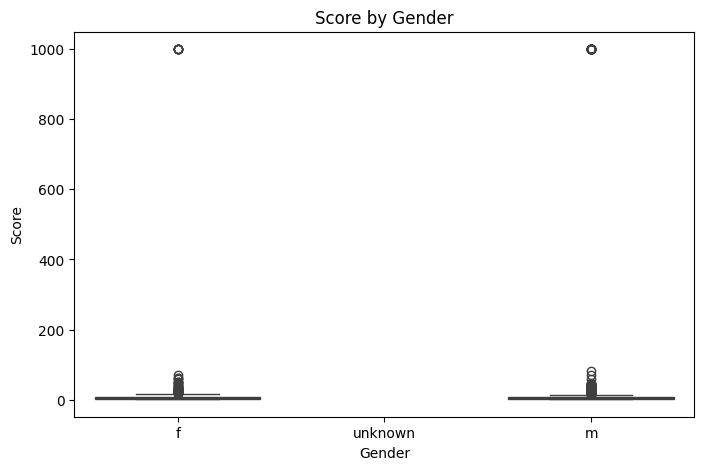

In [ ]:
# Score by Gender
plt.figure(figsize=(8, 5))
sns.boxplot(x='gender', y='score', data=characters)
plt.title('Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Score')
plt.show()

# Lines dataset

Let's have a look in the lines dataset which is a collection of dialogs of the movies.

In [ ]:
lines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293202 entries, L1045 to L666256
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   charID        288917 non-null  object 
 1   movieID       288917 non-null  object 
 2   charName      288874 non-null  object 
 3   text          293202 non-null  object 
 4   polarity      293202 non-null  float64
 5   subjectivity  293202 non-null  float64
dtypes: float64(2), object(4)
memory usage: 23.7+ MB


First 5 rows in the lines

In [ ]:
lines.head()

charID movieID charName          text  polarity  subjectivity
lineID                                                              
L1045      u0      m0   BIANCA  They do not!       0.0           0.0
L1044      u2      m0  CAMERON   They do to!       0.0           0.0
L985       u0      m0   BIANCA    I hope so.       0.0           0.0
L984       u2      m0  CAMERON     She okay?       0.5           0.5
L925       u0      m0   BIANCA     Let's go.       0.0           0.0

Textblob is used for sentiment analysis as it is easy to use for common text processing

In [ ]:
!pip install textblob

This step ensures consistency and compatibility of the data for further analysis.

In [ ]:
# Convert NaNs to empty strings
lines['text'] = lines['text'].fillna('')

# Convert all values in the 'text' column to strings
lines['text'] = lines['text'].astype(str)


The code calculates two sentiment metrics:
Polarity: A numerical value indicating the positivity or negativity of the text (-1 being very negative, 1 being very positive). Subjectivity: A numerical value indicating how subjective or objective the text is (0 being very objective, 1 being very subjective)

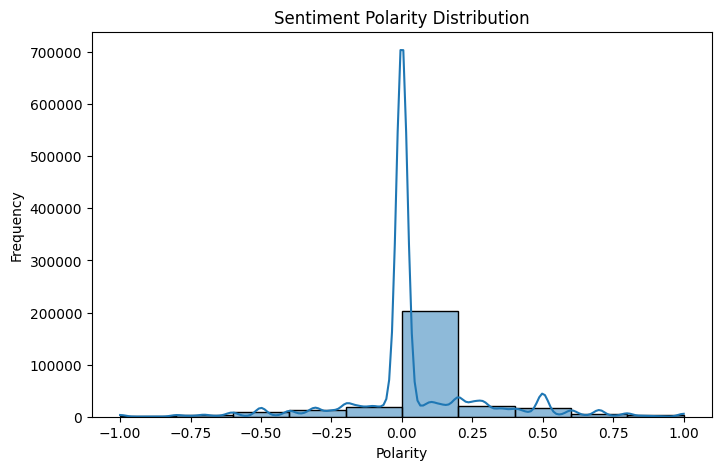

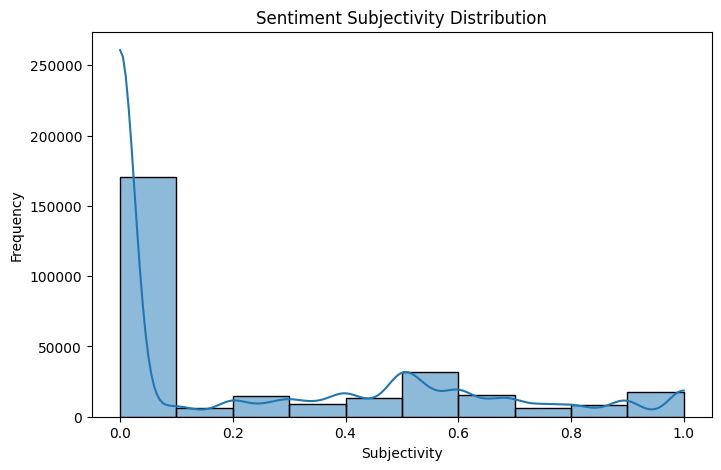

In [ ]:
from textblob import TextBlob

# Function to get the sentiment polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis
lines['polarity'], lines['subjectivity'] = zip(*lines['text'].apply(get_sentiment))

# Visualize sentiment polarity
plt.figure(figsize=(8, 5))
sns.histplot(lines['polarity'], bins=10, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

# Visualize sentiment subjectivity
plt.figure(figsize=(8, 5))
sns.histplot(lines['subjectivity'], bins=10, kde=True)
plt.title('Sentiment Subjectivity Distribution')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.show()


Generating word clouds for characters like Bianca and Cameron can help visualize the most common words they use in their dialogue.

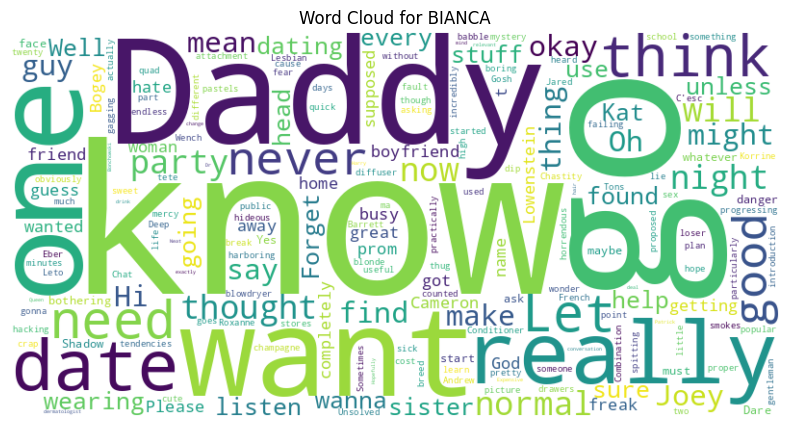

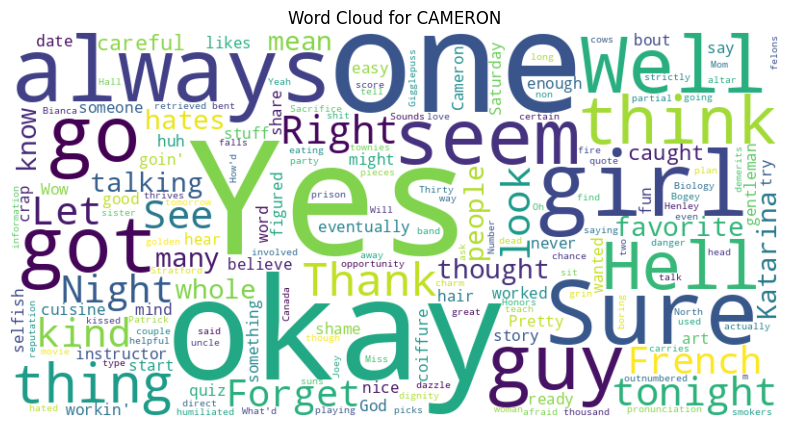

In [ ]:
from wordcloud import WordCloud

# Function to generate word cloud for a given character
def generate_wordcloud(character):
    text = ' '.join(lines[lines['charName'] == character]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {character}')
    plt.axis('off')
    plt.show()

# Generate word clouds for BIANCA and CAMERON
generate_wordcloud('BIANCA')
generate_wordcloud('CAMERON')


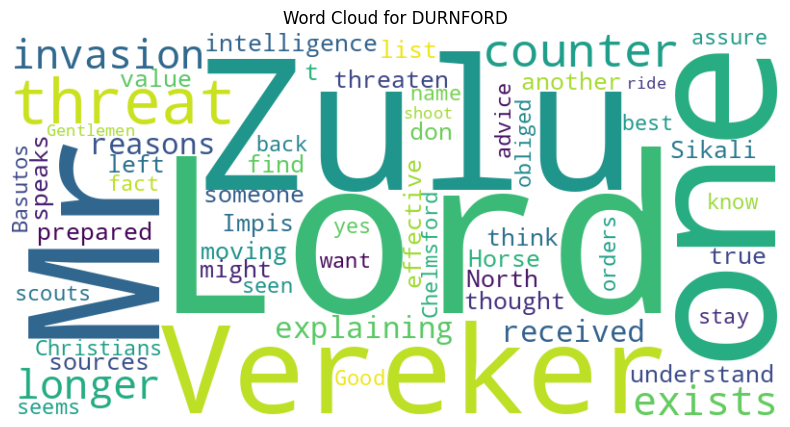

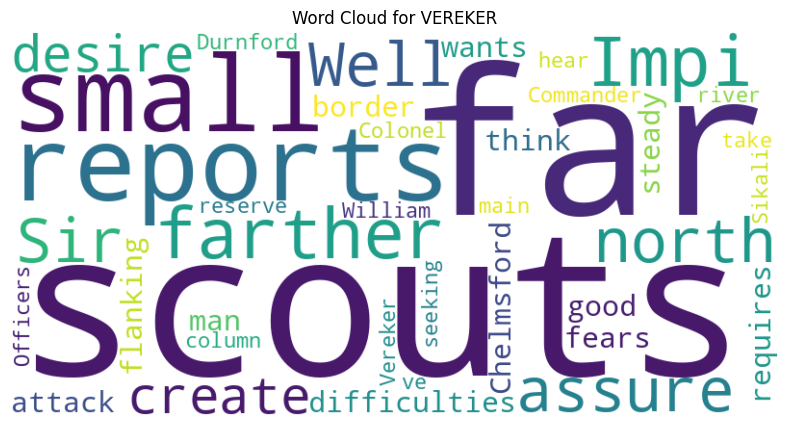

In [ ]:
# Generate word clouds for DURNFORD and VEREKER
generate_wordcloud('DURNFORD')
generate_wordcloud('VEREKER')

**Text length:** The distribution of text length provides insights into the typical length, variability, and speech patterns of dialogue lines spoken by characters in the dataset. It helps understand average dialogue length, variability in speech patterns, emotional intensity, engagement levels, and character communication styles. Visualizing this distribution allows for quick insights into the nature of the textual data.

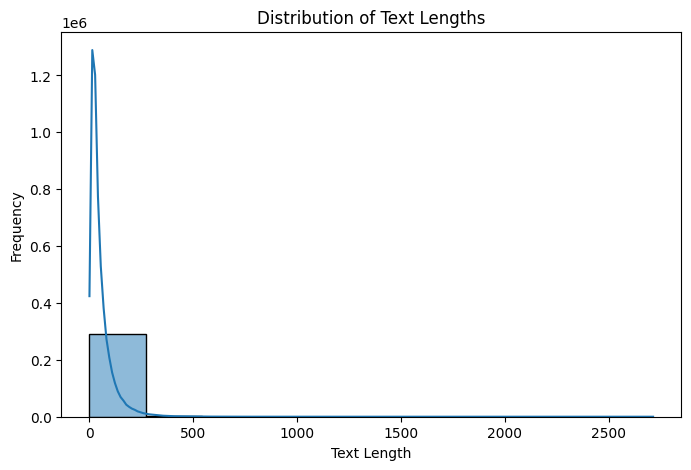

In [ ]:
# Add a column for text length
lines['text_length'] = lines['text'].apply(len)

# Distribution of text lengths
plt.figure(figsize=(8, 5))
sns.histplot(lines['text_length'], bins=10, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Conversations Dataset

Overlook on the Conversations dataset.

In [ ]:
conversations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83097 entries, 0 to 83096
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   charID_1      83097 non-null  object
 1   charID_2      83097 non-null  object
 2   movieID       83097 non-null  object
 3   conversation  83097 non-null  object
 4   length        83097 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.2+ MB


head() shows the information of first 5 rows of the dataset.

In [ ]:
conversations.head()

charID_1 charID_2 movieID              conversation  length
0       u0       u2      m0  [L194, L195, L196, L197]       4
1       u0       u2      m0              [L198, L199]       2
2       u0       u2      m0  [L200, L201, L202, L203]       4
3       u0       u2      m0        [L204, L205, L206]       3
4       u0       u2      m0              [L207, L208]       2

**Getting Movie List**

In [ ]:
def get_movie_list(movies):
    movie_list = movies['title'].tolist()
    return movie_list

In [ ]:
movie_list = get_movie_list(titles)
print(movie_list[:50])

['10 things i hate about you', '1492: conquest of paradise', '15 minutes', '2001: a space odyssey', '48 hrs.', 'the fifth element', '8mm', 'a nightmare on elm street 4: the dream master', 'a nightmare on elm street: the dream child', 'the atomic submarine', 'affliction', 'air force one', 'airplane ii: the sequel', 'airplane!', 'alien nation', 'aliens', 'amadeus', 'an american werewolf in london', 'american madness', 'american outlaws', 'american psycho', 'antitrust', 'austin powers: international man of mystery', 'the avengers', 'bachelor party', 'backdraft', 'bad lieutenant', 'bamboozled', 'barry lyndon', 'basic', 'big fish', 'birthday girl', 'black snake moan', 'black rain', 'blade runner', 'blast from the past', 'blue velvet', 'the boondock saints', 'bottle rocket', 'the bourne supremacy', 'braveheart', 'the butterfly effect', 'casablanca', 'cast away', 'the cider house rules', 'confidence', 'croupier', 'dark star', 'dark angel', 'detroit rock city']


In [ ]:
len(movie_list)

617

The character column is converted into list by using tolist() for better accessing of the information.

In [ ]:
def get_chracter_list(character):
    character_list = character['charName'].tolist()
    return character_list


Total list of characters presented in dataset

In [ ]:
character_list = get_chracter_list(characters)
print(character_list[:100])

['BIANCA', 'BRUCE', 'CAMERON', 'CHASTITY', 'JOEY', 'KAT', 'MANDELLA', 'MICHAEL', 'MISS PERKY', 'PATRICK', 'SHARON', 'WALTER', 'ALONSO', 'AROJAZ', 'BEATRIX', 'BOBADILLA', 'COLUMBUS', 'FERNANDO', 'ISABEL', 'MARCHENA', 'MENDEZ', 'MOXICA', 'PINZON', 'SAILOR', 'SANCHEZ', 'UTAPAN', 'CUTLER', 'DAPHNE', 'DUFFY', 'EDDIE', 'EMIL', 'HAWKINS', 'HONEY', 'IMMIGRATION OFFICER', 'JORDY', 'KORFIN', 'LEON', 'MAGGIE', 'MAX', 'MILOS', 'MUGGER', 'NICOLETTE', 'OLEG', 'ROBERT HAWKINS', 'ROSE', 'SECONDARY OFFICER', 'STEPHEN GELLER', 'TOMMY', 'VENDOR', 'B20', 'BOWMAN', 'C12', 'CHILD', 'CO-PILOT', 'ELENA', 'FLOYD', 'HAL', 'MICHAELS', 'MILLER', 'PILOT', 'POOLE', 'SMYSLOV', 'ATTENDANT', 'BARTENDER', 'BILLY', 'CANDY', 'CASEY', 'CATES', 'ELAINE', 'GANZ', 'HADEN', 'HAMMOND', 'HENRY', 'KEHOE', 'LISA', 'LUTHER', 'SOSNA', 'YOUNG COP', 'CORNELIUS', 'DAVID', 'DIVA', 'FINGER', 'GIRL', 'KOMMANDER', 'KORBEN', 'LEELOO', 'LOC RHOD', 'MACTILBURGH', 'MOTHER', 'MUGGER', 'MUNRO', 'PRESIDENT', 'PRIEST', 'PROFESSOR', 'SECRETARY', '

The total length of characters can be known by len().

In [ ]:
len(character_list)

9034

In [ ]:
index_labels = titles.index
print(index_labels)

Index(['m0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9',
       ...
       'm607', 'm608', 'm609', 'm610', 'm611', 'm612', 'm613', 'm614', 'm615',
       'm616'],
      dtype='object', name='movieID', length=617)


# Extraction of Conversations

we are using indices of movie titles and movie ID to extract the conversations of characters.

In [ ]:
def extract_conversations_for_movies(movies_list, characters, movies, lines, conversations):
    movie_ids = [movies[movies['title'] == movie_title].index[0] for movie_title in movies_list]
    movie_conversations = {}

    for movie_id in movie_ids:
        # Get all conversations for this movie
        relevant_convos = conversations[conversations['movieID'] == movie_id]
        movie_title = movies.loc[movie_id].title
        if movie_title not in movie_conversations:
            movie_conversations[movie_title] = []

        # Loop through the relevant conversations
        for i, conversation in relevant_convos.iterrows():
            char_name1 = characters.loc[conversation['charID_1']].charName
            char_name2 = characters.loc[conversation['charID_2']].charName

            convo_text = []

            for lineID in conversation.conversation:
                try:
                    line = lines.loc[lineID]
                    convo_text.append(f"{line.charName} : {line.text}")
                except KeyError:
                    continue

            movie_conversations[movie_title].append(' '.join(convo_text))

    return movie_conversations


Here we have the Movie name from which the conversations are extracted.

In [ ]:
movies_list_test = movie_list[0:9]
data = extract_conversations_for_movies(movies_list_test, characters, titles, lines, conversations)
#print(data)

**Dialogues extraction:**

In [ ]:
dialogues = dict(zip(characters['charName'], lines['text']))
#print(dialogues)

Identifying the Movie from the conversation using movieID.

In [ ]:
def view_convo(conversation, characters, movies, lines):
    charID_1, charID_2, movieID = conversation['charID_1'], conversation['charID_2'], conversation['movieID']

    char1 = characters.loc[charID_1].charName
    char2 = characters.loc[charID_2].charName
    movie = movies.loc[movieID].title

    convo_header = f"This conversation was between {char1} and {char2}, from movie : {movie}."
    print(convo_header)
    print(f"{'-' * len(convo_header)}")

    for lineID in conversation.conversation:
        line = lines.loc[lineID]
        print(f"{line.charName} : {line.text}")

Viewing the conversations of first movie in the list.

In [ ]:
view_convo(conversations.iloc[0], characters, titles, lines)

This conversation was between BIANCA and CAMERON, from movie : 10 things i hate about you.
------------------------------------------------------------------------------------------
BIANCA : Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
CAMERON : Well I thought we'd start with pronunciation if that's okay with you.
BIANCA : Not the hacking and gagging and spitting part.  Please.
CAMERON : Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?


Viewing the conversations of last movie in the list.

In [ ]:
view_convo(conversations.iloc[-1], characters, titles, lines)

This conversation was between DURNFORD and VEREKER, from movie : zulu dawn.
---------------------------------------------------------------------------
VEREKER : Well I assure you Sir I have no desire to create difficulties. 45
DURNFORD : And I assure you you do not In fact I'd be obliged for your best advice. What have your scouts seen?
VEREKER : So far only their scouts. But we have had reports of a small Impi farther north over there. 


In [ ]:
len(conversations)

83097

# Finding Meta data of a conversation

In [ ]:
def find_convo_info(input_dialogue, lines, conversations, titles):
    for _, convo_row in conversations.iterrows():
        for line_id in convo_row['conversation']:
            if line_id in lines.index and input_dialogue in lines.loc[line_id, 'text']:
                movie_id = convo_row['movieID']
                char_name = lines.loc[line_id, 'charName']
                movie_info = titles.loc[movie_id]
                movie_title = movie_info['title']
                movie_year = movie_info['year']
                movie_rating = movie_info['ratingIMDB']
                movie_votes = movie_info['votes']
                movie_genres = ast.literal_eval(movie_info['genresIMDB'])
                movie_genres_str = ", ".join(movie_genres)
                return {
                    'movie_title': movie_title,
                    'movie_year': movie_year,
                    'movie_rating': movie_rating,
                    'movie_votes': movie_votes,
                    'movie_genres': movie_genres_str,
                    'character': char_name,
                    'dialogue': lines.loc[line_id, 'text']
                }
    return None


In [ ]:
#input_dialogue = input("Enter a string/ dialogue to search for meta data: ")
input_dialogue = "She okay?"
convo_info = find_convo_info(input_dialogue, lines, conversations, titles)
if convo_info:
    print(f"This conversation was between {convo_info['character']} and another character, from the movie: {convo_info['movie_title']} ({convo_info['movie_year']}).")
    print(f"IMDb Rating: {convo_info['movie_rating']} based on {convo_info['movie_votes']} votes.")
    print(f"Genres: {convo_info['movie_genres']}")
    print(f"Dialogue: {convo_info['dialogue']}")
else:
    print("Dialogue not found in the conversations dataset.")

This conversation was between CAMERON and another character, from the movie: 10 things i hate about you (1999.0).
IMDb Rating: 6.9 based on 62847.0 votes.
Genres: comedyromance
Dialogue: She okay?


In [ ]:
#input_dialogue = input("Enter a string/ dialogue to search for meta data: ")
input_dialogue = "What have your scouts seen?"
convo_info = find_convo_info(input_dialogue, lines, conversations, titles)
if convo_info:
    print(f"This conversation was between {convo_info['character']} and another character, from the movie: {convo_info['movie_title']} ({convo_info['movie_year']}).")
    print(f"IMDb Rating: {convo_info['movie_rating']} based on {convo_info['movie_votes']} votes.")
    print(f"Genres: {convo_info['movie_genres']}")
    print(f"Dialogue: {convo_info['dialogue']}")
else:
    print("Dialogue not found in the conversations dataset.")

This conversation was between DURNFORD and another character, from the movie: zulu dawn (1979.0).
IMDb Rating: 6.4 based on 1911.0 votes.
Genres: actionadventuredramahistorywar
Dialogue: And I assure you you do not In fact I'd be obliged for your best advice. What have your scouts seen?


Extracting the conversations as a list and viewing the last 100 lines from the list.

In [ ]:
convo_list = lines['text'].tolist()

# Print the list
print("Conversation in a list:")
print(convo_list[:10])


Conversation in a list:
['They do not!', 'They do to!', 'I hope so.', 'She okay?', "Let's go.", 'Wow', "Okay -- you're gonna need to learn how to lie.", 'No', nan, 'Like my fear of wearing pastels?']


Converting the list into a single string.

In [ ]:
conversation_string = ' '.join(convo_list)
# Display the result
print(conversation_string[:1000])

They do not! They do to! I hope so. She okay? Let's go. Wow Okay -- you're gonna need to learn how to lie. No  Like my fear of wearing pastels?  What good stuff? I figured you'd get to the good stuff eventually. Thank God!  If I had to hear one more story about your coiffure... Me.  This endless ...blonde babble. I'm like boring myself. What crap? do you listen to this crap? No...  You always been this selfish? But Then that's all you had to say. Well no... You never wanted to go out with 'me did you? I was?  Tons Have fun tonight? I believe we share an art instructor You know Chastity? Looks like things worked out tonight huh? Hi. Who knows?  All I've ever heard her say is that she'd dip before dating a guy that smokes. So that's the kind of guy she likes? Pretty ones? Lesbian?  No. I found a picture of Jared Leto in one of her drawers so I'm pretty sure she's not harboring same-sex tendencies. She's not a... I'm workin' on it. But she doesn't seem to be goin' for him. I really really

Find out the length of the converted string using len().

In [ ]:
len(conversation_string)

15713182

Cleaning of string by removing the punctuations and viewing.

In [ ]:
translator = str.maketrans('', '', string.punctuation)
# Remove punctuation from the string
cleaned_string = conversation_string.translate(translator)

print(cleaned_string[:1000])

They do not They do to I hope so She okay Lets go Wow Okay  youre gonna need to learn how to lie No  Like my fear of wearing pastels  What good stuff I figured youd get to the good stuff eventually Thank God  If I had to hear one more story about your coiffure Me  This endless blonde babble Im like boring myself What crap do you listen to this crap No  You always been this selfish But Then thats all you had to say Well no You never wanted to go out with me did you I was  Tons Have fun tonight I believe we share an art instructor You know Chastity Looks like things worked out tonight huh Hi Who knows  All Ive ever heard her say is that shed dip before dating a guy that smokes So thats the kind of guy she likes Pretty ones Lesbian  No I found a picture of Jared Leto in one of her drawers so Im pretty sure shes not harboring samesex tendencies Shes not a Im workin on it But she doesnt seem to be goin for him I really really really wanna go but I cant  Not unless my sister goes Sure have E

Viewing the length of cleaned string.

In [ ]:
len(cleaned_string)

14811992

As we can see the length is reduced from previous raw string.

Now, we can filter the string to words.

In [ ]:
# Split the string into words
vocabs = cleaned_string.split()

# Count the number of words
num_vocabs = len(vocabs)

print("Number of vocabularies:", num_vocabs)

Number of vocabularies: 2943886


Let's have a look at the last 100 vocabularies from the list.

In [ ]:
print(vocabs[:100])

['They', 'do', 'not', 'They', 'do', 'to', 'I', 'hope', 'so', 'She', 'okay', 'Lets', 'go', 'Wow', 'Okay', 'youre', 'gonna', 'need', 'to', 'learn', 'how', 'to', 'lie', 'No', 'Like', 'my', 'fear', 'of', 'wearing', 'pastels', 'What', 'good', 'stuff', 'I', 'figured', 'youd', 'get', 'to', 'the', 'good', 'stuff', 'eventually', 'Thank', 'God', 'If', 'I', 'had', 'to', 'hear', 'one', 'more', 'story', 'about', 'your', 'coiffure', 'Me', 'This', 'endless', 'blonde', 'babble', 'Im', 'like', 'boring', 'myself', 'What', 'crap', 'do', 'you', 'listen', 'to', 'this', 'crap', 'No', 'You', 'always', 'been', 'this', 'selfish', 'But', 'Then', 'thats', 'all', 'you', 'had', 'to', 'say', 'Well', 'no', 'You', 'never', 'wanted', 'to', 'go', 'out', 'with', 'me', 'did', 'you', 'I', 'was']


The Natural Language Tool Kit (NLTK) is a powerful library in python used for working with human language data(text). It provides a suite of calssification, text processing, parsing, tokenising and semantic reasoning.

In [ ]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Viewing the stopwords from the list as they are recursive.

In [ ]:
# Load the stopwords for English
stop_words = set(stopwords.words('english'))

# Remove stop words from the vocabulary
filtered_vocab = [word for word in vocabs if word not in stop_words]

# Display the filtered vocabulary
print("Filtered vocabulary:", filtered_vocab[:200])


Filtered vocabulary: ['They', 'They', 'I', 'hope', 'She', 'okay', 'Lets', 'go', 'Wow', 'Okay', 'youre', 'gonna', 'need', 'learn', 'lie', 'No', 'Like', 'fear', 'wearing', 'pastels', 'What', 'good', 'stuff', 'I', 'figured', 'youd', 'get', 'good', 'stuff', 'eventually', 'Thank', 'God', 'If', 'I', 'hear', 'one', 'story', 'coiffure', 'Me', 'This', 'endless', 'blonde', 'babble', 'Im', 'like', 'boring', 'What', 'crap', 'listen', 'crap', 'No', 'You', 'always', 'selfish', 'But', 'Then', 'thats', 'say', 'Well', 'You', 'never', 'wanted', 'go', 'I', 'Tons', 'Have', 'fun', 'tonight', 'I', 'believe', 'share', 'art', 'instructor', 'You', 'know', 'Chastity', 'Looks', 'like', 'things', 'worked', 'tonight', 'huh', 'Hi', 'Who', 'knows', 'All', 'Ive', 'ever', 'heard', 'say', 'shed', 'dip', 'dating', 'guy', 'smokes', 'So', 'thats', 'kind', 'guy', 'likes', 'Pretty', 'ones', 'Lesbian', 'No', 'I', 'found', 'picture', 'Jared', 'Leto', 'one', 'drawers', 'Im', 'pretty', 'sure', 'shes', 'harboring', 'samesex', 't

Finding out the length of filtered vocabulary using len().

In [ ]:
len(filtered_vocab)

1816291

Frequency of filtered vocabulary:

Here we found the most used word in the dataset.

In [ ]:
# Count the occurrences of each word
word_counts = Counter(filtered_vocab)

# Find the 10 most common words
most_common_words = word_counts.most_common(50)

print(most_common_words)

[('I', 95125), ('You', 26003), ('Im', 20730), ('know', 20002), ('dont', 18574), ('What', 15554), ('like', 12769), ('get', 11800), ('No', 10847), ('want', 10134), ('got', 10131), ('Its', 10007), ('think', 9747), ('The', 9732), ('And', 9305), ('one', 8428), ('going', 8256), ('right', 8113), ('go', 8046), ('Well', 8005), ('But', 7437), ('Oh', 6974), ('see', 6847), ('youre', 6760), ('He', 6551), ('We', 6524), ('Ill', 6361), ('Thats', 6235), ('time', 5933), ('It', 5847), ('Youre', 5810), ('Yes', 5771), ('cant', 5676), ('Yeah', 5568), ('back', 5521), ('us', 5400), ('How', 5318), ('tell', 5153), ('good', 5094), ('didnt', 5075), ('say', 5030), ('would', 5014), ('could', 4989), ('Ive', 4914), ('Why', 4913), ('man', 4741), ('So', 4637), ('something', 4624), ('mean', 4617), ('way', 4556)]


In [ ]:
conv = convo_list[:1000]

# **Vectorizing Text and finding cosine similarities**


We are converting the text data into numerical vectors using TF-IDF for further insights.


TF-IDF Vectorization: Converts the text data into numerical features using TF-IDF. Each document (movie dialogues) is represented as a TF-IDF vector.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature Extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(item) for item in data.values()])
tfidf_matrix


<9x4039 sparse matrix of type '<class 'numpy.float64'>'
	with 8251 stored elements in Compressed Sparse Row format>

In [ ]:
# Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = cosine_similarity(tfidf_matrix)

Cosine Similarity: Measures the cosine similarity between these TF-IDF vectors. Cosine similarity is a measure that calculates the cosine of the angle between two vectors, providing a similarity score ranging from -1 (exact opposite) to 1 (exactly the same).

In [ ]:
cosine_similarities

array([[1.        , 0.28399362, 0.37627471, 0.28780749, 0.30216646,
        0.30865982, 0.3079914 , 0.25051547, 0.2514007 ],
       [0.28399362, 1.        , 0.37085065, 0.30707145, 0.29439131,
        0.3267838 , 0.30361777, 0.2355602 , 0.24326171],
       [0.37627471, 0.37085065, 1.        , 0.37257231, 0.40274556,
        0.40320718, 0.44742061, 0.32669167, 0.327119  ],
       [0.28780749, 0.30707145, 0.37257231, 1.        , 0.30672295,
        0.33616096, 0.31735647, 0.25673337, 0.25963981],
       [0.30216646, 0.29439131, 0.40274556, 0.30672295, 1.        ,
        0.32697745, 0.32350932, 0.2737099 , 0.26628887],
       [0.30865982, 0.3267838 , 0.40320718, 0.33616096, 0.32697745,
        1.        , 0.33387696, 0.26638637, 0.2668693 ],
       [0.3079914 , 0.30361777, 0.44742061, 0.31735647, 0.32350932,
        0.33387696, 1.        , 0.27502758, 0.27558812],
       [0.25051547, 0.2355602 , 0.32669167, 0.25673337, 0.2737099 ,
        0.26638637, 0.27502758, 1.        , 0.65533757],


Following snippet compares an input sentence with a list of sentences (movie dialogues) to find the top 5 most similar sentences based on their cosine similarity. Here's what each step does:
Combine Sentences: The input sentence is combined with the list of sentences to form a new list (combined_sentences).
TF-IDF Vectorization: The TF-IDF vectorizer is applied to the combined sentences to convert them into TF-IDF vectors, which represent the importance of each word in the context of the entire dataset.
Cosine Similarity: The cosine similarity matrix is computed using the TF-IDF vectors. This matrix measures the similarity between each pair of sentences in the dataset.
Top Similarities: The cosine similarity matrix is flattened, and the indices of the top 5 most similar sentences (excluding the input sentence itself) are identified.
Retrieve Top Similar Sentences: The top 5 similar sentences are retrieved from the original list of sentences based on the indices obtained in the previous step.
Print Results: Finally, the top 5 similar sentences are printed along with the input sentence for comparison.

In [ ]:
#input_sentence = input("Enter a string/ dialogue to find similar snetences from the movie dialogues: ")
input_sentence = "I love ice-cream"
sentences = [str(sentence).strip() for sentence in convo_list]
input_sentence = str(input_sentence).strip()

In [ ]:
# Combine the input sentence with the list of sentences
combined_sentences = sentences + [input_sentence]

# Create the TF-IDF vectorizer and transform the sentences
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_sentences)

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])

# Flatten the matrix and get the top 5 indices
similarities = cosine_sim_matrix.flatten()
top_indices = similarities.argsort()[-5:][::-1]

# Get the top 5 similar sentences
top_5_similar_sentences = [sentences[i] for i in top_indices]

print("Top 5 similar sentences from movie dialogues: "+input_sentence)
print('-------------------------------------------------')

for i, sentence in enumerate(top_5_similar_sentences, 1):
    print(f"{i}. {sentence}")

Top 5 similar sentences from movie dialogues: I love ice-cream
-------------------------------------------------
1. Ice cream!
2. Of COURSE!! Ice cream!!
3. ...the ice cream for money!
4. Hey look. Ice cream.
5. It's better than ice cream.


# K-means:


This code performs sentiment analysis and clustering on a subset of 10,000 conversations using **K-means**. It starts by analyzing the sentiment of each conversation with the VADER sentiment analyzer, classifying them as either "Positive" or "Negative." Then, it vectorizes the text using TF-IDF, clusters the conversations into three groups with K-Means, and replaces the cluster labels with the sentiment labels. Finally, it reduces the dimensionality of the TF-IDF matrix using PCA and visualizes the clusters in a 2D scatter plot, color-coded by sentiment.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK data
nltk.download('vader_lexicon')

convo_list_s = convo_list[:10000]

# Replace NaN values with an empty string
convo_list_s = [str(conversation) if isinstance(conversation, str) else '' for conversation in convo_list_s]

# Sentiment analysis
sid = SentimentIntensityAnalyzer()
sentiment_labels = []
for conversation in convo_list_s:
    # Ensure conversation is a string
    conversation = str(conversation)
    sentiment_score = sid.polarity_scores(conversation)['compound']
    if sentiment_score > 0.0:
        sentiment_labels.append('Positive')
    else:
        sentiment_labels.append('Negative')

# Vectorize the conversations using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(convo_list_s)

# Cluster the conversations using K-Means
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
labels = kmeans.labels_

# Replace cluster labels with sentiment labels
sentiment_clusters = np.array(sentiment_labels)[labels]

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_matrix = pca.fit_transform(tfidf_matrix.toarray())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


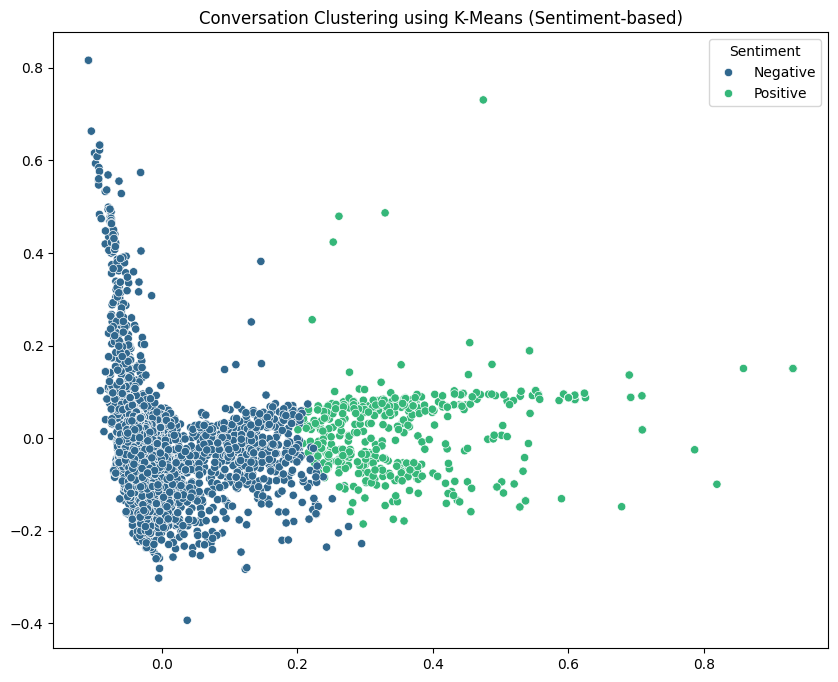

In [ ]:
# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_matrix[:, 0], y=reduced_matrix[:, 1], hue=sentiment_clusters, palette='viridis')
plt.title('Conversation Clustering using K-Means (Sentiment-based)')
plt.legend(title='Sentiment', loc='upper right')
plt.show()

This Python code performs sentiment analysis using k-means clustering. It starts by representing sentences as numerical vectors using TF-IDF (Term Frequency-Inverse Document Frequency) vectors. Then, it applies the k-means clustering algorithm to partition the sentences into 5 clusters based on their similarities. Each cluster represents a grouping of sentences with similar TF-IDF features.

In [ ]:
from sklearn.metrics import silhouette_score

convo_list_ss = convo_list[:2000]
# Convert sentences to numerical vectors (TF-IDF vectors)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)

# Apply k-means clustering
k = 5  # Number of clusters (you can adjust this based on your data)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Analyze clusters
cluster_labels = kmeans.labels_

# Calculate silhouette score to evaluate clustering quality
silhouette_avg = silhouette_score(X, cluster_labels)
print("Silhouette Score:", silhouette_avg)

# print some sentences from each cluster
for i in range(k):
    cluster_sentences = [sentences[j] for j in range(len(sentences)) if cluster_labels[j] == i]
    print(f"Cluster {i+1}:", cluster_sentences[:5])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.013502266860692688
Cluster 1: ['They do not!', 'I hope so.', 'She okay?', "Let's go.", 'Wow']
Cluster 2: ['What good stuff?', 'What crap?', 'Let me see what I can do.', 'What? To completely damage me?  To send me to therapy forever? What?', 'You did what?']
Cluster 3: ['They do to!', "I figured you'd get to the good stuff eventually.", 'I was?', "So that's the kind of guy she likes? Pretty ones?", "I'm workin' on it. But she doesn't seem to be goin' for him."]
Cluster 4: ["Okay -- you're gonna need to learn how to lie.", 'do you listen to this crap?', 'You always been this selfish?', "Then that's all you had to say.", "You never wanted to go out with 'me did you?"]
Cluster 5: ['No', 'No...', 'Well no...', "No no it's my fault -- we didn't have a proper introduction ---", 'No.']


Finally, the code analyzes the clusters to identify common themes or sentiment expressions within each cluster, providing insights into the sentiment distribution of the dataset.

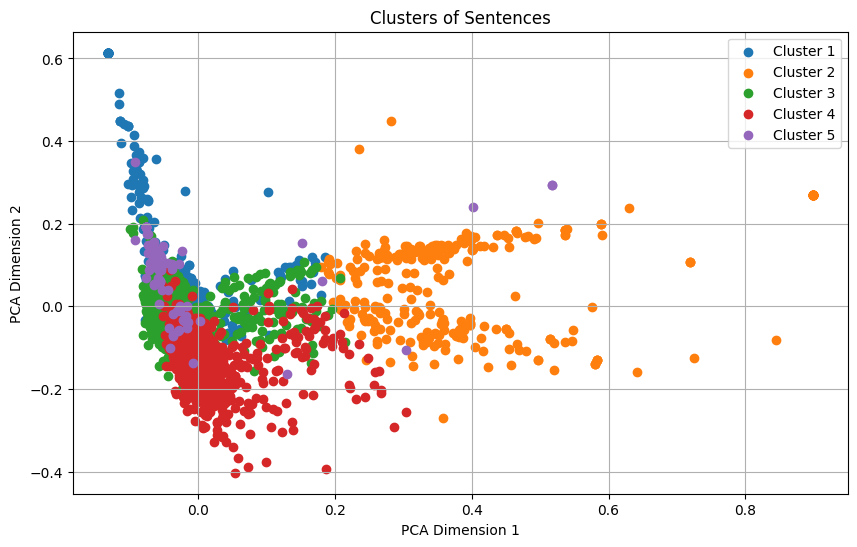

In [ ]:
# Step 1: Reduce dimensionality of sentence embeddings to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Step 2: Plot clusters in a scatter plot
plt.figure(figsize=(10, 6))
for i in range(k):
    cluster_sentences = [X_pca[j] for j in range(len(sentences)) if cluster_labels[j] == i]
    cluster_sentences = np.array(cluster_sentences)
    plt.scatter(cluster_sentences[:, 0], cluster_sentences[:, 1], label=f'Cluster {i+1}')

plt.title("Clusters of Sentences")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


# DBSCAN
This code performs sentiment analysis and clustering on a list of sentences. It uses the VADER sentiment analyzer to label each sentence as 'positive', 'negative', or 'neutral' based on their sentiment scores. Sentences are then vectorized using TF-IDF and clustered with the DBSCAN algorithm. DBSCAN parameters (eps=0.5, min_samples=5) are adjustable for better clustering performance. The silhouette score is calculated to evaluate clustering quality, with higher scores indicating better-defined clusters. This process helps group sentences by sentiment and evaluate the effectiveness of the clustering.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Determine sentiment polarity of each sentence
sentiment_scores = [sid.polarity_scores(sentence)['compound'] for sentence in convo_list_ss]

# Assign sentiment labels (positive, negative, neutral) based on sentiment scores
sentiment_labels = ['positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral' for score in sentiment_scores]

# Convert sentences to numerical vectors (TF-IDF vectors)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(convo_list_ss)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You may need to adjust these parameters
cluster_labels = dbscan.fit_predict(X)

# Print some sentences from each sentiment cluster
unique_sentiments = set(sentiment_labels)
for sentiment in unique_sentiments:
    sentiment_indices = [i for i in range(len(sentiment_labels)) if sentiment_labels[i] == sentiment]
    sentiment_sentences = [convo_list_ss[i] for i in sentiment_indices]
    print(f"{sentiment.capitalize()} Sentences:")
    for sentence in sentiment_sentences[:5]:
        print("  ", sentence)
    print()

# Evaluate clustering quality using silhouette score
silhouette_avg = silhouette_score(X, cluster_labels)
print("Silhouette Score:", silhouette_avg)


Positive Sentences:
   I hope so.
   She okay?
   Wow
   Okay -- you're gonna need to learn how to lie.
   What good stuff?

Neutral Sentences:
   They do not!
   They do to!
   Let's go.
   
   

Negative Sentences:
   No
   Like my fear of wearing pastels?
   What crap?
   do you listen to this crap?
   You always been this selfish?

Silhouette Score: -0.2361342986150655


Visualization: Plotting

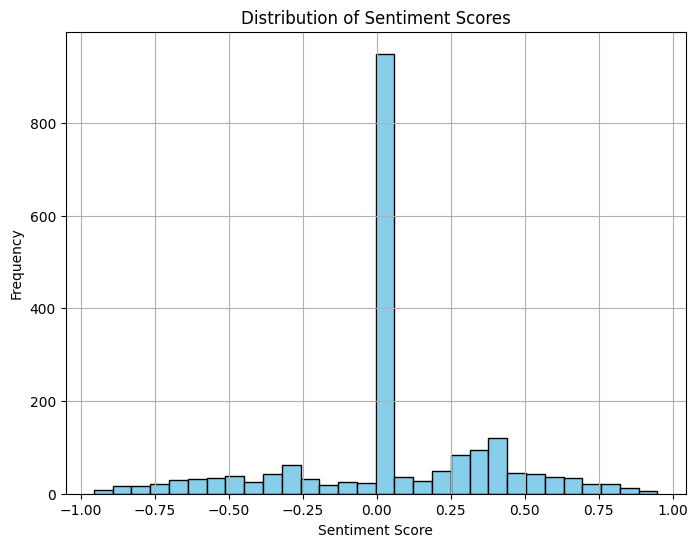

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(sentiment_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

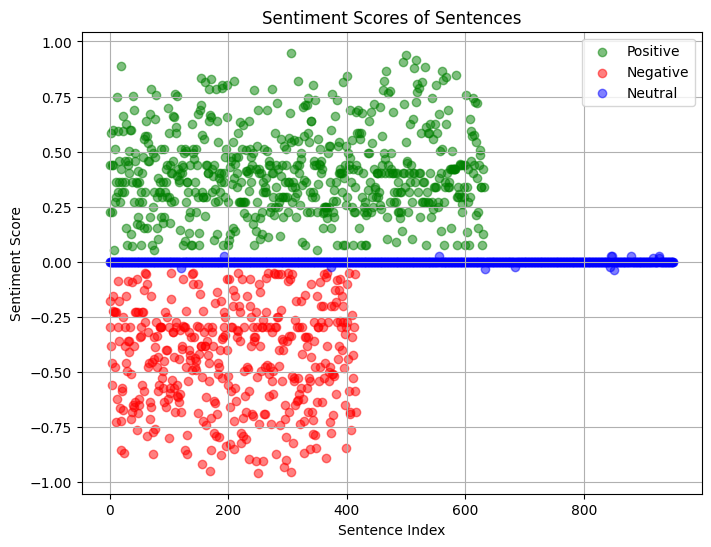

In [ ]:
# Segment sentiment scores based on labels
positive_scores = [score for score, label in zip(sentiment_scores, sentiment_labels) if label == 'positive']
negative_scores = [score for score, label in zip(sentiment_scores, sentiment_labels) if label == 'negative']
neutral_scores = [score for score, label in zip(sentiment_scores, sentiment_labels) if label == 'neutral']

# Create scatter plot of sentiment scores
plt.figure(figsize=(8, 6))
plt.scatter(range(len(positive_scores)), positive_scores, color='green', label='Positive', alpha=0.5)
plt.scatter(range(len(negative_scores)), negative_scores, color='red', label='Negative', alpha=0.5)
plt.scatter(range(len(neutral_scores)), neutral_scores, color='blue', label='Neutral', alpha=0.5)
plt.title('Sentiment Scores of Sentences')
plt.xlabel('Sentence Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

# BERT Model:

This task performs sentiment analysis using a pre-trained BERT model. It starts by processing a list of sentences, flattening it and removing any non-string values (e.g., NaN). Then, it utilizes a pre-trained BERT model for sequence classification to analyze the sentiment of each sentence. The sentiment score for each sentence is computed and plotted on a scatter plot. The color of each point on the scatter plot represents the sentiment rating range (1 star to 5 stars), with a specific color assigned to each range. This visualization provides an overview of the sentiment distribution across the dataset.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

# Function to flatten the list
def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list

In [ ]:
# Flatten the list
import torch
sentences = flatten(convo_list_ss)

# Remove nan values
sentences = [sentence for sentence in sentences if isinstance(sentence, str)]

# Load the pre-trained BERT model and tokenizer for sentiment analysis
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

In [ ]:
def sentiment_score(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        scores = [1, 2, 3, 4, 5]
        weighted_score = sum(prob * score for prob, score in zip(probabilities[0], scores))
    return weighted_score.item()

# Analyze the sentiment of each sentence and get the weighted scores
scores = [sentiment_score(sentence, tokenizer, model) for sentence in sentences]

Plotting the data in scatter plot

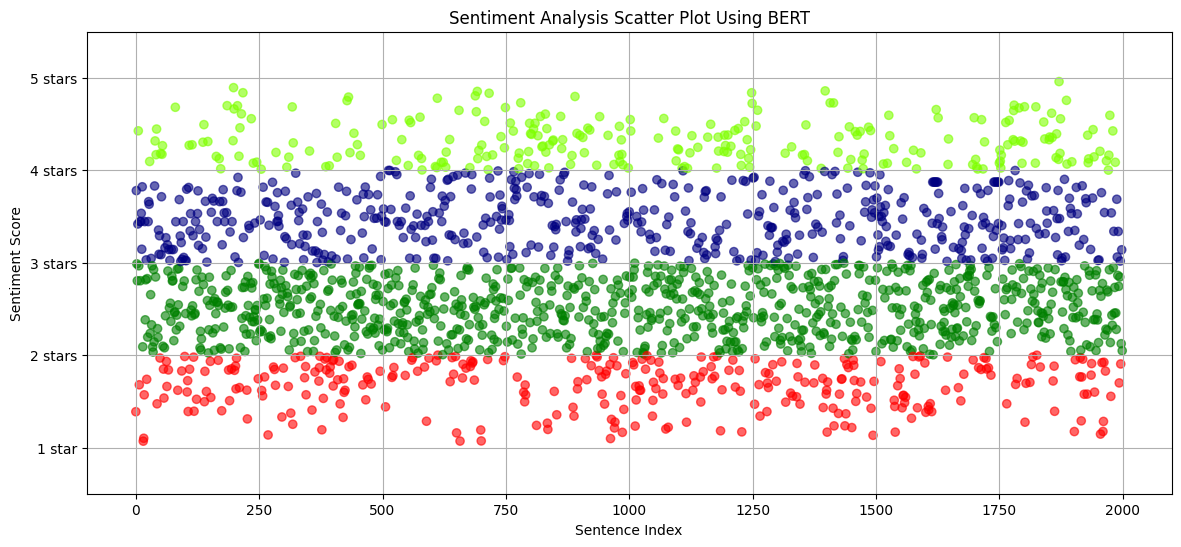

In [ ]:
def get_color(score):
    if score < 1.0:
        return 'orange'
    elif score < 2.0:
        return 'red'
    elif score < 3.0:
        return 'green'
    elif score < 4.0:
        return 'navy'
    else:
        return 'chartreuse'

colors = [get_color(score) for score in scores]

#Plotting
plt.figure(figsize=(14, 6))
plt.scatter(range(len(sentences)), scores, c=colors, alpha=0.6)
plt.title("Sentiment Analysis Scatter Plot Using BERT")
plt.xlabel("Sentence Index")
plt.ylabel("Sentiment Score")
plt.ylim(0.5, 5.5)  # Adjust the limits based on your sentiment score range
#plt.yticks(np.arange(1, 6, 0.5), ['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5'])
#plt.legend(title='Sentiment', loc='upper right')
plt.yticks(range(1, 6), ['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
plt.grid(True)

plt.show()

## Model Training

Installing the libraries we need for model training.

In [ ]:
!pip install transformers torch pandas
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install transformers torch pandas datasets accelerate

Conversion of Dialogues into list for better analysis. And here we are using the smaller version of dataset to save the time and memory as our main dataset is too large.

NB: The similar operation can be operated in the main dataset

In [ ]:
# Convert list to DataFrame
df = pd.DataFrame(conv, columns=['dialogue'])

# Drop rows with None or NaN values
df.dropna(inplace=True)

# Convert DataFrame back to list
cleaned_convo_list = df['dialogue'].tolist()

Saving the text file after removing other columns.

In [ ]:
# Save cleaned conversation to a text file
with open('cleaned_convo.txt', 'w') as f:
    for line in cleaned_convo_list:
        f.write(line + '\n')

# Training of dataset using GPT2 Model

We are using only 3 epochs just to demonstrate how the model works. Larrger epochs size will definetely increase the performances of the model

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset

# Load pre-trained model and tokenizer
model_name = 'gpt2'  # Ensure this is the smallest GPT-2 model
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

# Load dataset
dataset = load_dataset('text', data_files={'train': 'cleaned_convo.txt'})

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,
    fp16=True,
    save_steps=20_000,
    save_total_limit=2,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets['train']
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Train the model
trainer.train()

TrainOutput(global_step=45, training_loss=3.955638631184896, metrics={'train_runtime': 6085.0029, 'train_samples_per_second': 0.493, 'train_steps_per_second': 0.007, 'total_flos': 188130263040000.0, 'train_loss': 3.955638631184896, 'epoch': 2.88})

**Respose Generation**

Tokenization and generating a respose from the input text.

In [ ]:
import torch

# Load the fine-tuned model
model.eval()

# Generate text
input_text = "I want to eat pizza"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Create attention mask
attention_mask = torch.ones(input_ids.shape, device=input_ids.device)

# Generate text with attention mask and additional parameters to reduce repetition
output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=50,
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    repetition_penalty=2.0,
    pad_token_id=tokenizer.eos_token_id
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


I want to eat pizza.  I'm not sure what you're talking about... but we have a date! We'll see if he's okay with that? He doesn't seem like the type of guy who would go out for drinks and get


**Training GPT model using the Dialogues data:**

In [ ]:
# Shortening the Data
shorten_di = list(dialogues.items())[:1000]

# Convert back to a dictionary
s_dialogues = dict(shorten_di)

#print(s_dialogues)

In [ ]:
# Convert dictionary to a list of strings for training
dialogue_list = [f"{character}: {line}" for character, line in s_dialogues.items() if pd.notna(character) and pd.notna(line)]

# Save the dialogue to a text file
with open('dialogue_data.txt', 'w') as f:
    for line in dialogue_list:
        f.write(line + '\n')

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset

# Load pre-trained model and tokenizer
model_name = 'gpt2'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

# Load dataset
dataset = load_dataset('text', data_files={'train': 'dialogue_data.txt'})

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Reduce batch size to 1
    gradient_accumulation_steps=16,  # Accumulate gradients over 8 steps
    fp16=True,  # Enable mixed precision training
    save_steps=20_000,
    save_total_limit=2,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets['train']
)

# Train the model
trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/986 [00:00<?, ? examples/s]

In [ ]:
import torch

# Load the fine-tuned model
model.eval()

# Generate text
input_text = "I hate my nose"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Create attention mask
attention_mask = torch.ones(input_ids.shape, device=input_ids.device)

# Generate text with attention mask and additional parameters to reduce repetition
output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=50,
    num_return_sequences=1,
    no_repeat_ngram_size=2,  # Avoid repeating n-grams
    repetition_penalty=2.0,  # Penalize repetition
    pad_token_id=tokenizer.eos_token_id
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


I hate my nose. I'm not going to lie: it's a shame that he didn't get his own way with this one."
"You're right," she said, "but you can always go back and do something else for him


# Dialoge generation

In [ ]:
import torch

# Ensure the model is in evaluation mode
model.eval()

def generate_response(prompt, max_new_tokens=100, temperature=0.7, top_k=50, top_p=0.9):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, device=input_ids.device)
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=len(input_ids[0]) + max_new_tokens,  # Adjust max_length to include input length
        num_return_sequences=1,
        no_repeat_ngram_size=2,  # Avoid repeating n-grams
        repetition_penalty=2.0,  # Penalize repetition
        temperature=temperature,  # Sampling temperature
        top_k=top_k,  # Top-k sampling
        top_p=top_p,  # Top-p (nucleus) sampling
        pad_token_id=tokenizer.eos_token_id
    )
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

# dialogue = input('Enter a string to start a dialogue: ')
dialogue = ["Lets play cricket"]


# Number of turns in the dialogue
num_turns = 3

# Alternating speakers
speakers = ['B', 'A']

for turn in range(1, num_turns + 1):
    # Determine the current speaker
    current_speaker = speakers[turn % 2]
    # Create the prompt from the existing dialogue
    prompt = '\n'.join(dialogue) + f'\n{current_speaker}:'
    # Generate the response
    response = generate_response(prompt)
    # Extract the response of the current speaker
    response = response.split(f"{current_speaker}:")[-1].strip()
    # Append the response to the dialogue
    dialogue.append(f"{current_speaker}: {response}")

# Join the dialogue into a single string for output
formatted_dialogue = '\n'.join(dialogue)
print(formatted_dialogue)


Lets play cricket
A: I'm not sure if you're ready for it. You've got to get out of here and go home now!  But don't worry, we'll be back soon enough... We can do this together again later tonight or tomorrow morning at least....
B: Okay? Well then let's start with the game first thing in bed.. Let me just take a look around my room before going into sleep so that your eyes are clear when he wakes up!!
A: Oh no!!! He doesn't have any clothes on him yet but his hair is still pretty much all black from yesterday night till today.  So what did she say about how cute her little sister was?! She said something like "I think our date will probably end by midnight". And there ya went - goodnight everyone!
